#**PROBLEMA DE NEGOCIO**


---




##Una tienda online de moda, con presencia en todo Brasil, necesita impulsar su rendimiento utilizando sus datos de manera estratégica. Como científico de datos, has sido convocado para analizar estos datos y ofrecer insights que guíen sus decisiones y respondan a las siguientes preguntas clave:

### **Preguntas**

1. ¿Cual es el Top 5 productos más vendidos históricamente?

2. ¿Cual es la evolución histórica de las ingresos netos?

3. ¿Cuáles son los ingresos netos por vendedor por año?

4. ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?

5. ¿Existe otro insight que puedas proporcionar?

#**1. Configuración del Ambiente**


---




In [126]:
!pip install geobr
import geobr
import geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tabulate import tabulate
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import requests
from io import BytesIO
from sqlalchemy import create_engine, MetaData, Table, inspect, text
global df_items_pedidos, df_pedidos, df_productos, df_vendedores, database
import warnings
warnings.filterwarnings("ignore")

#**2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---




##**2.1 Cargando las bases de datos**

In [127]:
df_items_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/itens_pedidos.csv')
df_items_pedidos.head()

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0
3,4,3820,1652,6,139,834,BR-DF,166.8
4,5,29012,2470,3,525,1575,BR-BA,315.0


In [128]:
df_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/pedidos.csv')
df_pedidos.head()

,pedido_id,producto_id,vendedor_id,fecha_compra,total
0,341,41518,6,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575


In [129]:
df_productos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/productos.csv')
df_productos.head()

,producto_id,producto,precio,marca,sku,condicion
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297.0,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612.0,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482.0,Usado
3,47475,Calca Alfaiataria Preta,490,Mixed,263658.0,Usado
4,74864,Vestido Jeans Babados,130,Zara,219248.0,Usado


In [130]:
df_vendedores = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/vendedores.csv')
df_vendedores.head()

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca


##**2.2 Tratamiento de Datos**

In [131]:
print(df_items_pedidos.info())
print('-------------')
print(df_pedidos.info())
print('-------------')
print(df_productos.info())
print('-------------')
print(df_vendedores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pedido_id     24527 non-null  int64 
 1   producto_id   24527 non-null  int64 
 2   vendedor_id   24527 non-null  int64 
 3   fecha_compra  24527 non-null  object
 

Definimos algunas funciones que nos seran utiles en el preprocesamiento

In [132]:
def check_valores_unicos(df):
  for columna in df.columns:
    numero = df[columna].value_counts(dropna=False)
    print(f"{columna} has {len(numero)} unique elements\n")
    print(f"{numero}\n")

def reiniciar_index(dframes_list):
  for i in dframes_list:
    i.reset_index(drop=True, inplace=True)

def eliminar_duplicados_tablas(dframes_list):
  for i in dframes_list:
    i = i.drop_duplicates()

#### 2.2.1 df_vendedores

In [133]:
check_valores_unicos(df_vendedores)

vendedor_id has 6 unique elements

vendedor_id
1    1
2    1
3    1
4    1
5    1
6    1
Name: count, dtype: int64

nombre_vendedor has 6 unique elements

nombre_vendedor
Ana Duarte         1
Daniel Siqueira    1
Nadia Oliveira     1
Millena Pereira    1
Paulo Calanca      1
Unknown            1
Name: count, dtype: int64



- Se observo que existe un vendedor desconocido denominado Unknown, lo que nos podria dificultar al momento de presentar los ingresos netos por vendedor por año
- Se asume que podría ser un vendedor que ya no existe o se olvidó de registrar el nombre.
- Procederemos a explicar la situación al cliente para que decida qué medidas tomar al respecto

In [134]:
df_vendedores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   vendedor_id      6 non-null      int64 
 1   nombre_vendedor  6 non-null      object
dtypes: int64(1), object(1)
memory usage: 224.0+ bytes


#### 2.2.2 df_productos

In [135]:
check_valores_unicos(df_productos)

producto_id has 207 unique elements

producto_id
21244    1
53941    1
67445    1
66255    1
4853     1
        ..
70673    1
98964    1
86302    1
13472    1
32926    1
Name: count, Length: 207, dtype: int64

producto has 202 unique elements

producto
NaN                        2
Saia Pregas Preta          2
Calca Jeans Costuras       2
Vestido Recortes Cores     2
Calca Alfaiataria Preta    2
                          ..
Shorts Listras Bordados    1
Saia Lurex Color           1
Body Estampa Coracoes      1
Peeptoe Preto Verniz       1
Capa Fio Marrom            1
Name: count, Length: 202, dtype: int64

precio has 85 unique elements

precio
320     13
390     10
210      8
120      7
350      7
        ..
1600     1
135      1
2630     1
750      1
1120     1
Name: count, Length: 85, dtype: int64

marca has 117 unique elements

marca
Zara               23
Mixed              14
Animale             9
Le Lis Blanc        6
Banana Republic     6
                   ..
Thay Ribas          1

- Se observo que en las columnas productos y sku hay valores nulos
- Al observar los diferentes productos de df_productos fue curioso encontrar productos que aparacen mas de una vez en el registro

In [136]:
df_productos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   producto_id  207 non-null    int64  
 1   producto     205 non-null    object 
 2   precio       207 non-null    int64  
 3   marca        207 non-null    object 
 4   sku          205 non-null    float64
 5   condicion    207 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.8+ KB


In [137]:
#Identificando las filas que presentan columnan con valores NaN
#Para visualizar los datos que poseen y si son relevantes
filtro = df_productos["producto"].isna()
df_temporal = df_productos[filtro]
df_temporal = pd.DataFrame(df_temporal)
df_temporal

,producto_id,producto,precio,marca,sku,condicion
205,41598,NaN,260,Banana Republic,NaN,Nuevo con etiqueta
206,32926,NaN,210,Limone By Jade Seba,NaN,Nuevo sin etiqueta


In [138]:
# Observamos las datos de sku
df_productos["sku"]

0      209297.0
1      278612.0
2      322482.0
3      263658.0
4      219248.0
         ...   
202    244931.0
203    247166.0
204    255410.0
205         NaN
206         NaN
Name: sku, Length: 207, dtype: float64

- ¿Es necesario la columna sku para el objetivo de éste análisis o la base de datos?

SKU significa “código de referencia” (stock keeping unit, por sus siglas en inglés) y, como lo indica su nombre, es un número (usualmente de ocho dígitos alfanuméricos) que las tiendas asignan a los productos para tener un registro interno de los niveles de existencias. Si un producto tiene diferentes colores y tamaños, cada variación tiene un número SKU diferente.

- Podemos considerar la opcion de eliminar la columna sku debido a que no afectara a la obtencion de insigths del banco de datos

In [139]:
# Nos preguntamos el porque algunos productos tienen mas de 1 aparicion
# Revisamos algunos de los elementos que presentan mas de 1 aparicion
apariciones_2 = ["Calca Alfaiataria Preta","Vestido Recortes Cores","Calca Alfaiataria Preta","Saia Pregas Preta"]
for i in apariciones_2:
  filtro = df_productos["producto"]==i
  df_temporal = df_productos[filtro]
  df_temporal = pd.DataFrame(df_temporal)
  print(tabulate(df_temporal, headers='keys', tablefmt='psql'))

+----+---------------+-------------------------+----------+--------------+--------+-------------+
|    |   producto_id | producto                |   precio | marca        |    sku | condicion   |
|----+---------------+-------------------------+----------+--------------+--------+-------------|
|  3 |         47475 | Calca Alfaiataria Preta |      490 | Mixed        | 263658 | Usado       |
| 26 |         11218 | Calca Alfaiataria Preta |      250 | Le Lis Blanc | 952813 | Usado       |
+----+---------------+-------------------------+----------+--------------+--------+-------------+
+-----+---------------+------------------------+----------+-------------+--------+-------------+
|     |   producto_id | producto               |   precio | marca       |    sku | condicion   |
|-----+---------------+------------------------+----------+-------------+--------+-------------|
|  93 |         18790 | Vestido Recortes Cores |      890 | Bcbgmaxzria | 264965 | Usado       |
| 186 |         15875 | 

- Nos damos cuenta que pese a ser el mismo producto presenta diferentes precios y marcas

#### 2.2.3 df_pedidos

In [140]:
check_valores_unicos(df_pedidos)

pedido_id has 24527 unique elements

pedido_id
341       1
86226     1
94031     1
93957     1
92781     1
         ..
115766    1
115121    1
114487    1
113453    1
65274     1
Name: count, Length: 24527, dtype: int64

producto_id has 205 unique elements

producto_id
32126     154
100481    148
47405     147
13814     144
33976     144
         ... 
29650     100
72667     100
89334      99
84743      96
88368      94
Name: count, Length: 205, dtype: int64

vendedor_id has 6 unique elements

vendedor_id
5    5282
1    5167
2    5032
3    4840
4    4205
6       1
Name: count, dtype: int64

fecha_compra has 780 unique elements

fecha_compra
2019-11-24    212
2020-12-02     97
2020-12-03     93
2020-11-30     92
2019-11-25     86
             ... 
2019-01-11      1
2019-01-09      1
2019-01-08      1
2019-01-07      1
2019-01-21      1
Name: count, Length: 780, dtype: int64

total has 354 unique elements

total
960      411
840      411
360      410
2100     369
600      349
        ...

- Se observa que hay un vendedor que realizo una sola venta

In [141]:
# Revisamos quien podria ser el vendedor que realizo 1 venta
# Y el total de la venta
filtro_1 = df_pedidos["vendedor_id"] == 6
df_temporal_1 = df_pedidos[filtro_1]
df_temporal_1 = pd.DataFrame(df_temporal_1)

filtro_2 = df_vendedores["vendedor_id"] == 6
df_temporal_2 = df_vendedores[filtro_2]
df_temporal_2 = pd.DataFrame(df_temporal_2)

filtro_3 = df_items_pedidos["pedido_id"] == 341
df_temporal_3 = df_items_pedidos[filtro_3]
df_temporal_3 = pd.DataFrame(df_temporal_3)

filtro_4 = df_productos["producto_id"] == 41518
df_temporal_4 = df_productos[filtro_4]
df_temporal_4 = pd.DataFrame(df_temporal_4)

print("En df_pedidos")
print(tabulate(df_temporal_1, headers='keys', tablefmt='psql'))
print("En df_vendedores")
print(tabulate(df_temporal_2, headers='keys', tablefmt='psql'))
print("En df_items_pedidos")
print(tabulate(df_temporal_3, headers='keys', tablefmt='psql'))
print("En df_productos")
print(tabulate(df_temporal_4, headers='keys', tablefmt='psql'))

En df_pedidos
+----+-------------+---------------+---------------+----------------+---------+
|    |   pedido_id |   producto_id |   vendedor_id | fecha_compra   |   total |
|----+-------------+---------------+---------------+----------------+---------|
|  0 |         341 |         41518 |             6 | 2019-01-05     |     780 |
+----+-------------+---------------+---------------+----------------+---------+
En df_vendedores
+----+---------------+-------------------+
|    |   vendedor_id | nombre_vendedor   |
|----+---------------+-------------------|
|  5 |             6 | Unknown           |
+----+---------------+-------------------+
En df_items_pedidos
+----+-------------+---------------+-------------+------------+------------------+---------------+----------+---------------+
|    |   id_recibo |   producto_id |   pedido_id |   cantidad |   valor_unitario |   valor_total | ciudad   |   costo_envio |
|----+-------------+---------------+-------------+------------+------------------+

- El vendedor que realizo una venta es Unknown con una venta de 780

In [142]:
df_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pedido_id     24527 non-null  int64 
 1   producto_id   24527 non-null  int64 
 2   vendedor_id   24527 non-null  int64 
 3   fecha_compra  24527 non-null  object
 4   total         24527 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 958.2+ KB


- La columna fecha_compra tiene un tipo de dato inadeacuado (object)

#### 2.2.4 df_items_pedidos

In [143]:
check_valores_unicos(df_items_pedidos)

id_recibo has 24527 unique elements

id_recibo
1        1
16643    1
16652    1
16651    1
16650    1
        ..
8174     1
8173     1
8172     1
8171     1
25055    1
Name: count, Length: 24527, dtype: int64

producto_id has 205 unique elements

producto_id
32126     154
100481    148
47405     147
13814     144
33976     144
         ... 
29650     100
72667     100
89334      99
84743      96
88368      94
Name: count, Length: 205, dtype: int64

pedido_id has 24527 unique elements

pedido_id
341       1
86226     1
94031     1
93957     1
92781     1
         ..
115766    1
115121    1
114487    1
113453    1
65274     1
Name: count, Length: 24527, dtype: int64

cantidad has 6 unique elements

cantidad
1    4146
5    4136
4    4121
3    4116
6    4025
2    3983
Name: count, dtype: int64

valor_unitario has 85 unique elements

valor_unitario
320     1508
390     1191
450      865
420      862
210      848
        ... 
1100     106
4000     106
530      105
345      104
6175     101
N

In [144]:
df_items_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB


#### 2.2.5 Funcion pre-procesamiento

- Creamos una funcion para cambiar los tipos de datos

In [145]:
def changeType():
  global df_items_pedidos, df_pedidos, df_productos, df_vendedores
  df_pedidos['fecha_compra'] = pd.to_datetime(df_pedidos['fecha_compra'])
  df_productos = df_productos.astype({
    'precio': 'float'
  })
  df_items_pedidos = df_items_pedidos.astype({
    'valor_unitario': 'float',
    'valor_total': 'float',
  })

- Nuestro cliente, luego de presentarle las observaciones que se obtuvieron en el preprocesamiento, indico que no desea ningun dato de tipo desconocido
- Por lo que se decidio eliminar los registros que presenten al vendedor Unknown y la columna sku

In [146]:
def preprocesamiento():
  global df_items_pedidos, df_pedidos, df_productos, df_vendedores
  # Eliminanos duplicados si es que hubiese
  eliminar_duplicados_tablas([df_productos, df_vendedores, df_items_pedidos, df_pedidos])
  # Cambiamos los tipos de datos de algunas columnas
  df_pedidos['fecha_compra'] = pd.to_datetime(df_pedidos['fecha_compra'])
  df_productos = df_productos.astype({'precio': 'float'})
  df_items_pedidos = df_items_pedidos.astype({'valor_unitario': 'float','valor_total': 'float'})
  # Eliminamos la columna "sku" de df_products
  del df_productos["sku"]
  # Elinamos las filas que no tienen producto definido en df_productos
  df_productos.dropna(inplace = True)
  # Eliminamos la venta de unknown del registro
  df_pedidos.drop([0], inplace = True)
  df_items_pedidos.drop([0], inplace = True)
  df_productos.drop([204], inplace=True)
  df_vendedores.drop([5], inplace=True)
  # Reiniciamos el index
  reiniciar_index([df_productos, df_pedidos, df_items_pedidos])

### Resumen del preprocesamiento:

1. Eliminamos la columna "sku"
2. Eliminamos los registros que no tengan un vendedor o producto conocido
3. Cambiamos los tipos de datos de algunas columnas
4. Eliminamos duplicados




In [147]:
preprocesamiento()
print(df_items_pedidos.info())
print('-------------')
print(df_pedidos.info())
print('-------------')
print(df_productos.info())
print('-------------')
print(df_vendedores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24526 entries, 0 to 24525
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24526 non-null  int64  
 1   producto_id     24526 non-null  int64  
 2   pedido_id       24526 non-null  int64  
 3   cantidad        24526 non-null  int64  
 4   valor_unitario  24526 non-null  float64
 5   valor_total     24526 non-null  float64
 6   ciudad          24526 non-null  object 
 7   costo_envio     24526 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24526 entries, 0 to 24525
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24526 non-null  int64         
 1   producto_id   24526 non-null  int64         
 2   vendedor_id   24526 non-null  int64         
 3 

##**2.3 Análisis Exploratorio (EDA)**

In [148]:
def numericals_boxplot_analisis(dataframe):
  numericals = dataframe.select_dtypes(include=['int', 'float']).columns
  fig, ax = plt.subplots(nrows=len(numericals), ncols=1, figsize=(10,15))
  fig.subplots_adjust(hspace=2)
  for index, column in enumerate(numericals):
    sns.boxplot(x=column, data=dataframe, ax=ax[index])
    ax[index].set_title(column)
    ax[index].set_xticklabels(ax[index].get_xticklabels())

### 2.3.1. Análisis exploratorio de df_vendedores

In [149]:
df_vendedores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   vendedor_id      5 non-null      int64 
 1   nombre_vendedor  5 non-null      object
dtypes: int64(1), object(1)
memory usage: 208.0+ bytes


In [150]:
df_vendedores

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca


In [151]:
df_vendedores[df_vendedores['vendedor_id'].duplicated()]

,vendedor_id,nombre_vendedor


In [152]:
df_vendedores['nombre_vendedor'].value_counts()

nombre_vendedor
Ana Duarte         1
Daniel Siqueira    1
Nadia Oliveira     1
Millena Pereira    1
Paulo Calanca      1
Name: count, dtype: int64

In [153]:
for i in df_vendedores.select_dtypes(include=['int', 'float']).columns:
  print(i)

vendedor_id


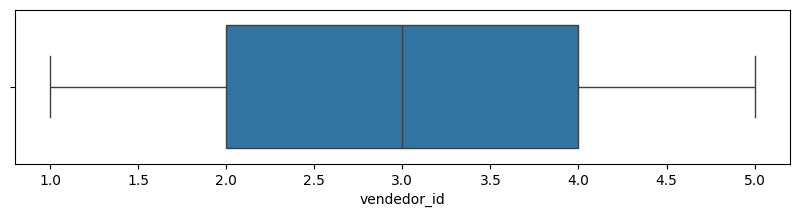

In [154]:
fig, ax = plt.subplots(figsize=(10,2))
sns.boxplot(x='vendedor_id', data=df_vendedores)
plt.show()

No se encuentran valores anómalos para el id de los vendedores

### 2.3.2. Análisis exploratorio de df_productos

In [155]:
df_productos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   producto_id  204 non-null    int64  
 1   producto     204 non-null    object 
 2   precio       204 non-null    float64
 3   marca        204 non-null    object 
 4   condicion    204 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 8.1+ KB


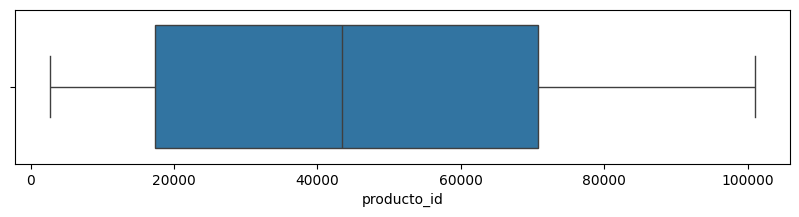

In [156]:
fig, ax = plt.subplots(figsize=(10,2))
sns.boxplot(x='producto_id', data=df_productos)
plt.show()

No se encuentran valores anómalos para el id de productos

In [157]:
df_productos[df_productos[['producto_id', 'producto']].duplicated()]

,producto_id,producto,precio,marca,condicion


Confirmamos la decisión de haber eliminado la columna SKU en pasos anteriores y efectivamente cada producto está identificado por su producto_id de manera única

In [158]:
df_productos['precio'].describe()

count     204.000000
mean      537.362745
std       845.627144
min        45.000000
25%       210.000000
50%       338.000000
75%       457.500000
max      6500.000000
Name: precio, dtype: float64

#### Análisis de las variables categóricas

Condición

<Axes: xlabel='condicion', ylabel='count'>

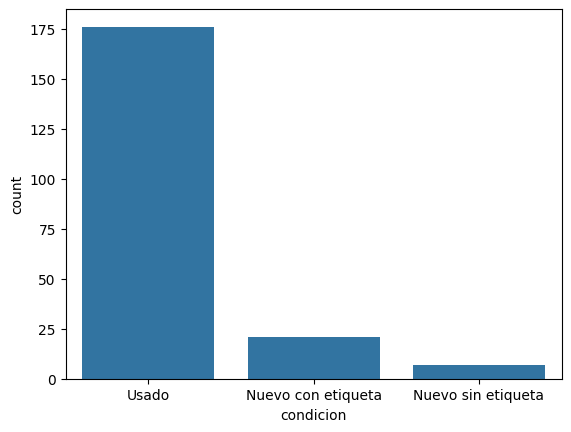

In [159]:
sns.countplot(x='condicion', data=df_productos)

Marca

In [160]:
df_productos['marca'].value_counts()

marca
Zara              23
Mixed             14
Animale            9
Le Lis Blanc       6
Farm               4
                  ..
Thay Ribas         1
Carter’s           1
American Eagle     1
Isolda             1
Express            1
Name: count, Length: 117, dtype: int64

Productos

In [161]:
df_productos['producto'].value_counts()

producto
Calca Alfaiataria Preta    2
Saia Pregas Preta          2
Vestido Recortes Cores     2
Calca Jeans Costuras       2
Oculos Lente Azulada       1
                          ..
Blusa Preta Aplicacao      1
Shorts Listras Bordados    1
Saia Lurex Color           1
Body Estampa Coracoes      1
Regata Bicolor Alcinha     1
Name: count, Length: 200, dtype: int64

Conclusión: Analizamos el dataframe de productos:


1.   No encontramos blancos, errores tipográficos ni tampoco nulos.
2.   Verificamos que cada producto está identificado por su único ID



### 2.3.3. Análisis exploratorio de df_pedidos

In [162]:
df_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24526 entries, 0 to 24525
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24526 non-null  int64         
 1   producto_id   24526 non-null  int64         
 2   vendedor_id   24526 non-null  int64         
 3   fecha_compra  24526 non-null  datetime64[ns]
 4   total         24526 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 958.2 KB


In [163]:
df_pedidos['fecha_compra'].value_counts().sort_index()

fecha_compra
2019-01-05     8
2019-01-06     2
2019-01-07     1
2019-01-08     1
2019-01-09     1
              ..
2021-02-21    23
2021-03-07     6
2021-03-08     4
2021-03-09     2
2021-03-10     3
Name: count, Length: 780, dtype: int64

No detectamos fechas mayores a la fecha actual. El último registro de venta que tenemos es del 10/03/21

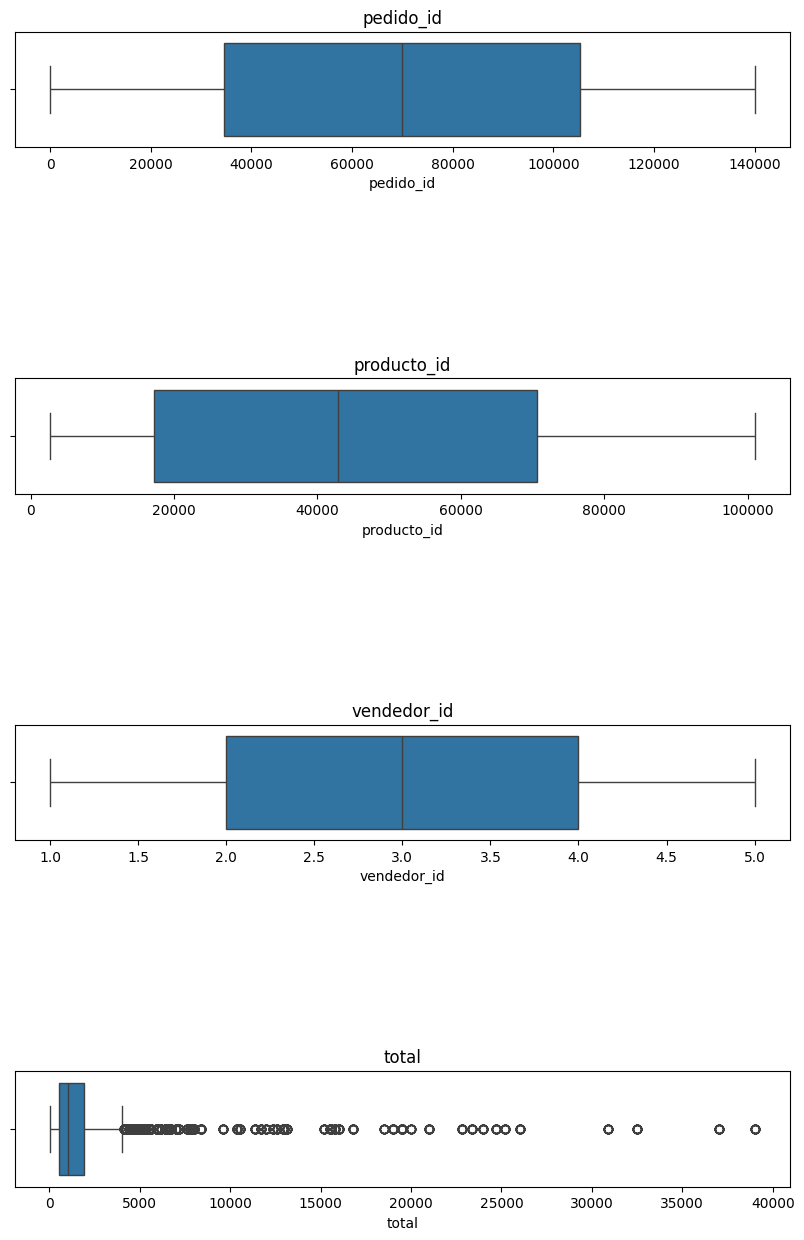

In [164]:
numericals_boxplot_analisis(df_pedidos)

Después de un análisis exploratorio concluimos que no hay valores anómalos para las columnas numéricas... como valores negativos.
Sí detectamos outliers en los totales pero sigue siendo información.

### 2.3.3. Análisis exploratorio de df_items_pedidos

In [165]:
df_items_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24526 entries, 0 to 24525
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24526 non-null  int64  
 1   producto_id     24526 non-null  int64  
 2   pedido_id       24526 non-null  int64  
 3   cantidad        24526 non-null  int64  
 4   valor_unitario  24526 non-null  float64
 5   valor_total     24526 non-null  float64
 6   ciudad          24526 non-null  object 
 7   costo_envio     24526 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 1.5+ MB


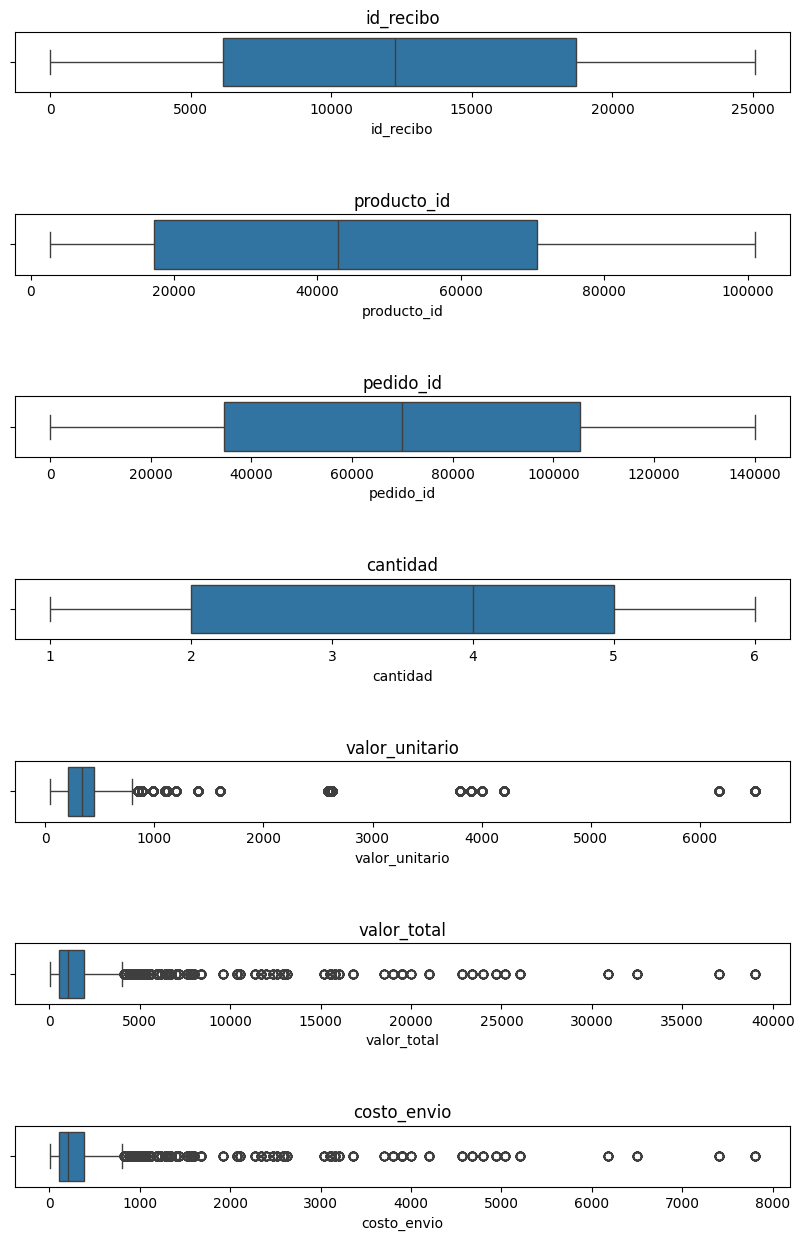

In [166]:
numericals_boxplot_analisis(df_items_pedidos)

No se encuentran valores anómalos en las columnas numéricas

[Text(0, 0, 'BR-RJ'),
 Text(1, 0, 'BR-PB'),
 Text(2, 0, 'BR-DF'),
 Text(3, 0, 'BR-BA'),
 Text(4, 0, 'BR-MG'),
 Text(5, 0, 'BR-PR'),
 Text(6, 0, 'BR-MS'),
 Text(7, 0, 'BR-SP'),
 Text(8, 0, 'BR-GO'),
 Text(9, 0, 'BR-AM'),
 Text(10, 0, 'BR-CE'),
 Text(11, 0, 'BR-RS'),
 Text(12, 0, 'BR-AC'),
 Text(13, 0, 'BR-RO'),
 Text(14, 0, 'BR-MT'),
 Text(15, 0, 'BR-RR'),
 Text(16, 0, 'BR-PE'),
 Text(17, 0, 'BR-MA'),
 Text(18, 0, 'BR-PA'),
 Text(19, 0, 'BR-SC'),
 Text(20, 0, 'BR-SE'),
 Text(21, 0, 'BR-TO'),
 Text(22, 0, 'BR-AP'),
 Text(23, 0, 'BR-PI'),
 Text(24, 0, 'BR-ES'),
 Text(25, 0, 'BR-AL'),
 Text(26, 0, 'BR-RN')]

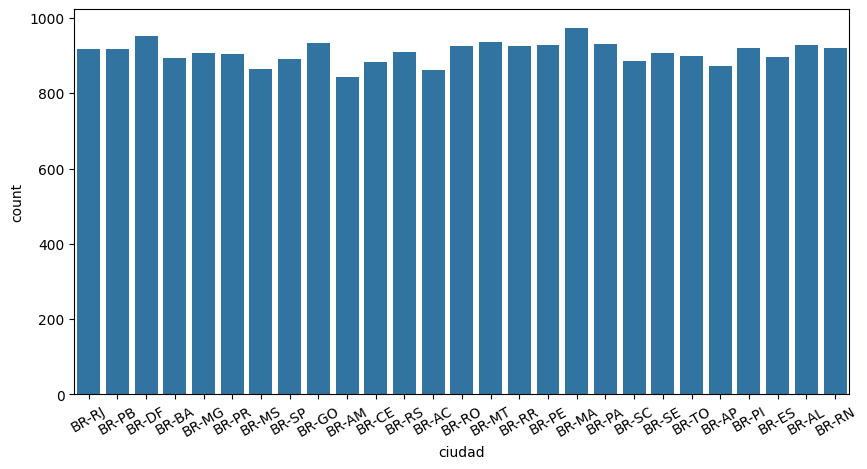

In [167]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x='ciudad', data=df_items_pedidos)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

No se encontraron errores tipográficos

### Análisis de redundancia


Modificaciones en df_pedidos
1.   Se elimina columna producto_id por redundancia
2.   Se elimina columna total por redundancia.

Modificaciones de df_items_pedidos


1.   Se elimina id_recibo. No aporta información






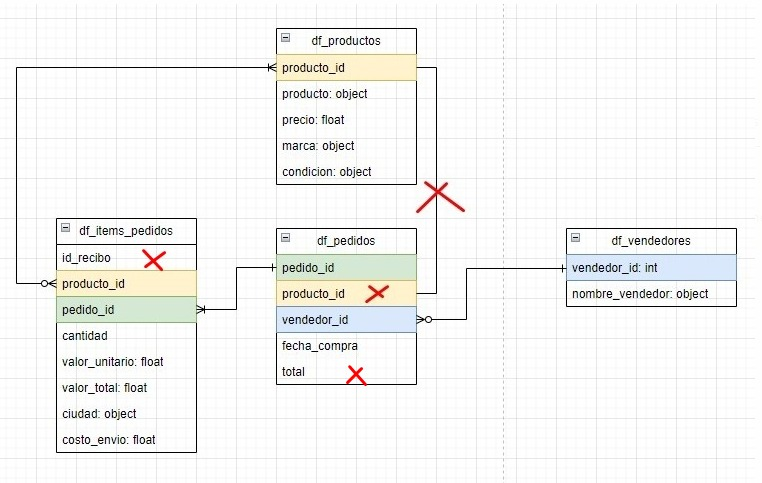![image.png]()

In [168]:
df_pedidos.drop(columns=['producto_id', 'total'], inplace=True)
df_items_pedidos.drop(columns='id_recibo', inplace=True)

### Modelo final

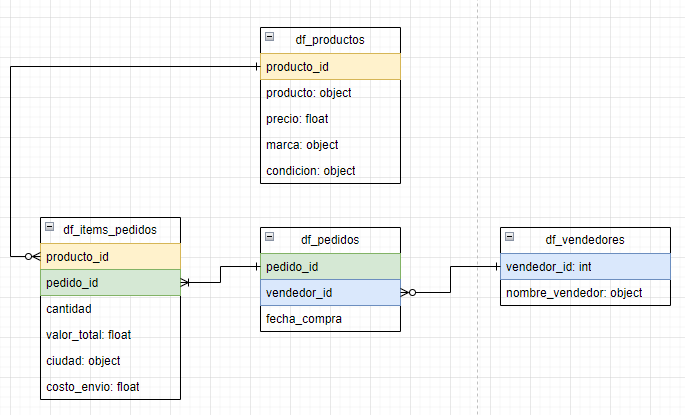

#**3. Preguntas y respuestas**


---




##**3.1 Creando el banco de datos**

In [169]:
#@title
def crear_conexion():
  global df_items_pedidos, df_pedidos, df_productos, df_vendedores, database
  database = create_engine('sqlite:///:memory:')
  df_items_pedidos.to_sql('items_pedidos',database, index=False)
  df_pedidos.to_sql('pedidos',database, index=False)
  df_productos.to_sql('productos',database, index=False)
  df_vendedores.to_sql('vendedores',database, index=False)

In [170]:
crear_conexion()
inspector = inspect(database)
print('Tablas: ', inspector.get_table_names(), '\n')
print('Columnas de Tabla Pedidos:')
for column in inspector.get_columns('pedidos'):
    print(column)
#database.dispose()

Tablas:  ['items_pedidos', 'pedidos', 'productos', 'vendedores'] 

Columnas de Tabla Pedidos:
{'name': 'pedido_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'vendedor_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'fecha_compra', 'type': DATETIME(), 'nullable': True, 'default': None, 'primary_key': 0}


##**Pregunta 1: ¿Cual es el Top 5 productos más vendidos históricamente?**

In [171]:
crear_conexion()
query ='''
select
    ip.producto_id,
    p.producto,
    p.marca,
    sum(ip.valor_total) as total_vendido,
    sum(ip.cantidad) as cantidad_vend
from
    items_pedidos ip
inner join
    productos p on ip.producto_id = p.producto_id
group by
    ip.producto_id, p.producto, p.marca
order by
    cantidad_vend DESC
limit
    5;
'''
df = pd.read_sql(sql=text(query), con=database.connect())
database.dispose()
df

,producto_id,producto,marca,total_vendido,cantidad_vend
0,32126,Saia Midi Cinto,Limone By Jade Seba,115290.0,549
1,13814,Vestido Nude Reta,Ellus,300850.0,547
2,47405,Blusa Manga Estampa,Animale,166160.0,536
3,33976,Camisa Xadrez Azul,Hollister,61320.0,511
4,53941,Cropped Escritas Pb,Linda de Morrer,142240.0,508


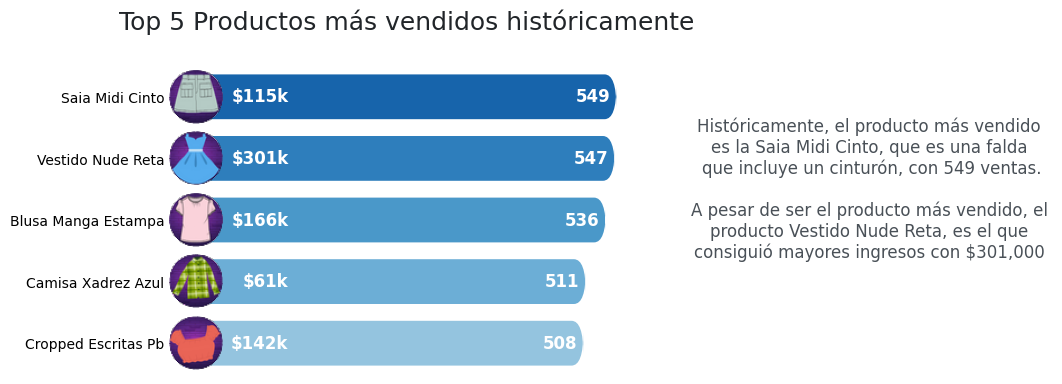

In [172]:
crear_conexion()
query ='''
select
    ip.producto_id,
    p.producto,
    p.marca,
    sum(ip.valor_total) as total_vendido,
    sum(ip.cantidad) as cantidad_vend
from
    items_pedidos ip
inner join
    productos p on ip.producto_id = p.producto_id
group by
    ip.producto_id, p.producto, p.marca
order by
    cantidad_vend DESC
limit
    5;
'''
df = pd.read_sql(sql=text(query), con=database.connect())
database.dispose()

df['total_vendido'] = (df['total_vendido'] / 1000).apply(lambda x: f'${x:.0f}k')

images_paths = [
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/falda.png',
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/vestido.png',
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/blusa.png',
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/camisa.png',
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/cropped.png'
]

plt.subplots(figsize=(6, 4))  #tamaño del gráfico

colores_azules = plt.cm.Blues_r(np.linspace(0.2, 0.6, len(df)))
ax = sns.barplot(x=df.cantidad_vend / 20, y=df.producto, orient='h', joinstyle='bevel')

new_patches = []

for patch, color, producto, cantidad_vendida, total_vendido, image_path in zip(ax.patches, colores_azules, df['producto'], df['cantidad_vend'], df['total_vendido'], images_paths):
    bb = patch.get_bbox()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.05,rounding_size=0.73",
                            fc=color, mutation_aspect=0.73,edgecolor="none")
    patch.remove()
    new_patches.append(p_bbox)

    response = requests.get(image_path)
    image=plt.imread(BytesIO(response.content))
    imagebox=OffsetImage(image,zoom=0.8)
    ab=AnnotationBbox(imagebox,xy=(1.35, patch.get_y() + patch.get_height()/2),
                      xybox=(0,0), xycoords='data',boxcoords="offset points",
                      pad=0,arrowprops=dict(arrowstyle='-',color='none'),
                      bboxprops=dict(facecolor='none',edgecolor='none'))
    ax.add_artist(ab)

    ax.annotate(f'{cantidad_vendida}', xy=(patch.get_width(), patch.get_y() + patch.get_height() / 2),
                xytext=(-5, 0), textcoords='offset points',
                arrowprops=dict(arrowstyle='-', color='none'),
                color='white', fontweight='bold', fontsize=12, ha='right', va='center',
                xycoords='data',
                bbox=dict(facecolor='none', edgecolor='none', pad=0),
                annotation_clip=False)

    ax.annotate(f'{total_vendido}', xy=(7.5, patch.get_y() + patch.get_height() / 2),
                xytext=(-5, 0), textcoords='offset points',
                arrowprops=dict(arrowstyle='-', color='none'),
                color='white', fontweight='bold', fontsize=12, ha='right', va='center',
                xycoords='data',
                bbox=dict(facecolor='none', edgecolor='none', pad=0),
                annotation_clip=False)

for patch in new_patches:
    ax.add_patch(patch)

# conclusión al gráfico
conclusion_text = (
    "Históricamente, el producto más vendido \n"
    "es la Saia Midi Cinto, que es una falda \n"
    "que incluye un cinturón, con 549 ventas.\n\n"
    "A pesar de ser el producto más vendido, el \n"
    "producto Vestido Nude Reta, es el que \n"
    "consiguió mayores ingresos con $301,000 "
)
ax.text(1.5,0.6, conclusion_text, fontsize=12, color='#495057', va='center', ha='center', transform=ax.transAxes)

# personalizar el gráfico
ax.set_title('Top 5 Productos más vendidos históricamente\n', loc='center', fontsize=18, color='#212529')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.yaxis.grid(False)
ax.xaxis.grid(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

##**Pregunta 2: ¿Cual es la evolución histórica de las ingresos netos?**

In [173]:
crear_conexion()
# Realizamos un query entre la tabla items_pedidos y pedidos
# donde seleccionamos y traemos la columna fecha_compra y una
# columna nueva derivada de la resta entre la columna valor_total
# y columna costo_envio, ambas de la tabla item, luego hacemos una
# agrupación por la fecha de comprar y ordenamos de manera ascendente
# con respecto a la fecha de compra es decir ira desde la fecha más
# antigua hasta la más reciente
evoluacion_historica = '''
                       SELECT
                       pedidos.fecha_compra,
                       SUM(valor_total - costo_envio) as total_ventas
                       FROM pedidos
                       INNER JOIN items_pedidos
                       ON items_pedidos.pedido_id = pedidos.pedido_id
                       GROUP BY pedidos.fecha_compra
                       ORDER BY fecha_compra ASC;
                       '''
df = pd.read_sql(evoluacion_historica, con = database.connect())
df

,fecha_compra,total_ventas
0,2019-01-05 00:00:00.000000,31836.8
1,2019-01-06 00:00:00.000000,1728.0
2,2019-01-07 00:00:00.000000,1560.0
3,2019-01-08 00:00:00.000000,1024.0
4,2019-01-09 00:00:00.000000,400.0
...,...,...
775,2021-02-21 00:00:00.000000,30944.8
776,2021-03-07 00:00:00.000000,4744.0
777,2021-03-08 00:00:00.000000,16206.4
778,2021-03-09 00:00:00.000000,4128.0


Ahora haremos la consulta de las marcas con las mayores ganancias el 24 de noviembre del 2019, que fue el día con mayores ventas registradas, usaremos esta información para crear un gráfico de torta.

In [174]:
# En esta consulta estamos trayendo información de 3 tablas, estamos trayendo
# la columna marca de la tabla productos, estamos generando una nueva columna
# llamada total_ventas con las columnas valor_total y costo_envio y hacemos
# un inner join entre items_pedidos y pedidos a través de la columna pedido_id
# en ambas tablas, y tambien un innter entre la tabla productos y items_pedidos
# a tráves de su tabla en comun producto_id, podríamos ver items_pedidos como
# nuestra tabla de hechos y las otras dos como nuestras tablas de dimensiones.
# Bueno todo esto tendra como condición la fecha 2019-11-24 que es el día donde
# se presentaron más ventas y agruparemos por la marca y orderamos por el total
# de ventas que ira desde la marca que más vendio hasta la que menos vendio
marcas_mas_vendidas = '''
                       SELECT
                       SUM(valor_total-costo_envio) as total_ventas,
                       productos.marca
                       FROM pedidos
                       INNER JOIN items_pedidos
                       ON items_pedidos.pedido_id = pedidos.pedido_id
                       INNER JOIN productos
                       ON productos.producto_id = items_pedidos.producto_id
                       WHERE strftime('%Y-%m-%d', pedidos.fecha_compra) == '2019-11-24'
                       GROUP BY productos.marca
                       ORDER BY total_ventas DESC;
                       '''

df2 = pd.read_sql(marcas_mas_vendidas, con = database.connect())
# Vamos hallar los porcentajes con los que trabajaremos nuestro gráfico de pie.
# Estamos realizando un suma de los valores en la columna total_ventas y lo
# estamos guardando en un nueva columna llamada total
df2['total'] = df2['total_ventas'].sum()
# Hallamos el porcentaje y lo guardamos en un nueva columna llamada porcentaje
df2['porcentaje'] = (((df2['total_ventas']/df2['total'] )* 100))
# Seleccionamos los 5 primeros registros de nuestro data frame, que serán los
# 5 con mayores ventas, ya que lo ordenamos de esta forma cuando realizamos la
# consulta y por ultimo lo redondeamos.
top_5 = df2.head(5).round()
# Ahora borramos la columna total y total_ventas y solo nos quedaremos con las
# marcas y el porcentaje, que esto representa el porcentaje de ganancias dura-
# nte ese día generado por las marcas.
top_5_marca_porcentaje_venta = top_5.drop(['total_ventas','total'],axis=1)
# Ahora vamos a seeleccionar de nuestro dataframe original todas los porcentajes
# y las marcas que no son del top 5 y eliminamos las columnas de nuevo
otras_ventas = df2.iloc[5::,:].drop(['total_ventas','total'],axis=1)
# Sustituimos el nombre de todas las marcas por Otras de esta manera podremos
# realizar un groupby
otras_ventas['marca']= 'Otras'
# Agrupamos por marca y porcentaje y realizamos una sumatoría y por ultimo
# reseteamos el indice, esto nos genera un dataframe con un solo regístro
# que indica el porcentaje acumulado de las ventas para las demas marcas
# resumidos en un unico valor.
otras_ventas = otras_ventas.groupby('marca')['porcentaje'].sum().reset_index()
# Redondeamos el porcentaje
otras_ventas = otras_ventas.round()
# Concatenamos ambos dataframe dandonos como resultado un dataframe con 6 registro
# que indican el top 5 y ultimo es la representación de las demas marcas.
porcentaje_ventas_marca = pd.concat([top_5_marca_porcentaje_venta,otras_ventas]).reset_index(drop=True)

Ahora vamos a proceder con la creación de nuestras gráficas.

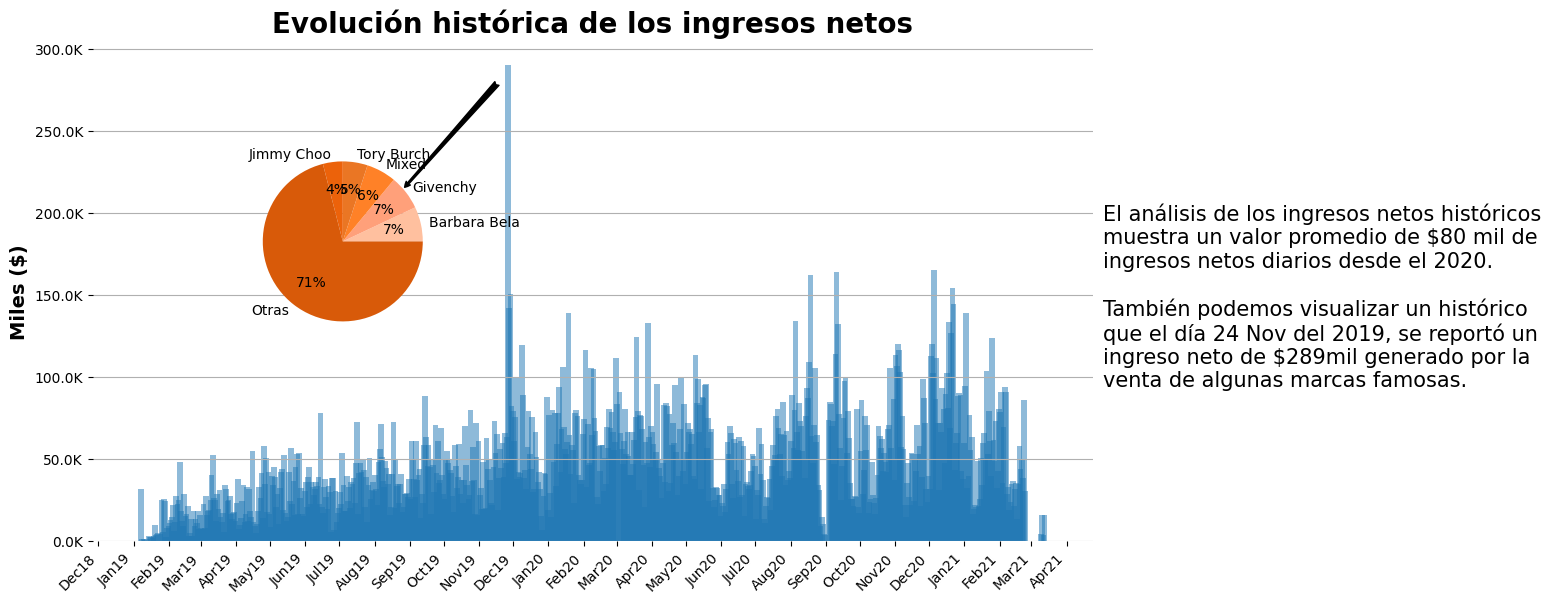

In [175]:
# Creamos la fig y el eje principal para el gráfico de barra
fig, ax = plt.subplots(figsize=(10,5))
# Añadimos el eje principal
ax = fig.add_axes([0,0,1,1])
# Añadimos insertamos un eje secundario en el principal, donde gráficaremos el gráfico
# de pie
ax2 = ax.inset_axes([0.05, 0.4, 0.4, 0.4])
# Establecemos el ejeX que sera nuestra fecha en formato datetime
ejeX = pd.to_datetime(df['fecha_compra'])
# Establecemos nues ejeY que almacena los valores totales de las ventas
ejeY = df['total_ventas']
# Creamos la variable barras, la cual almacena el primer gráfico y principal, el barras, el atributo alpha
# permite añadirle transparencia a las barras.
barras = ax.bar(ejeX, ejeY, width=5,align='edge',alpha=0.5)

#Estableceremos nuestros ticks en el eje X adecuadamente.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'  '%y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
# Formatemos nuestro valores del ejeY con el objetivo de mostrar un mejor intervalo de los ticks, para ello tambien usamos una lista
# para pasarle a la función max donde cada vez que crezca 1 el valor que muestra sea 50000 veces mayor.
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:0.1f}K'.format(x/1000)))
ax.yaxis.set_ticks(range(0, int(max([10000,50000,200000,300000])) + 1, 50000))
ax.set_title('Evolución histórica de los ingresos netos',fontsize=20,weight='bold')
ax.set_ylabel('Miles ($)',fontsize=14,weight='bold')
# Añadiremos lineas de cuadricula solo en el eje X
ax.grid(axis='y')
# Ahora haremos que los bordes negros del grafíco desaparezcan exceptuando el de la izquierda y el de abajo, para ello desactivaremos los spines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Realizando el gráfico de torta

# Datos a usar
marca = porcentaje_ventas_marca['marca']
porcentaje_Ventas = porcentaje_ventas_marca['porcentaje']

# Colores degradados
colores_torta = ['#FFC09F','#FFA07A','#FF8127','#EA7624','#EC620A','#D85A09']
ax2.pie(porcentaje_Ventas, labels=marca, autopct="%1.0f%%", colors=colores_torta, pctdistance = 0.65)
# Agregando una flecha para señalar el gráfico de barras como objetivo y parte de la barra que representa las ganancias del 2019-11-24
ax2.annotate("" , xy=(0.75, 0.65), xytext=(1.95, 2), ha='left', va='top', arrowprops=dict(arrowstyle='fancy', color='black'))
# Con xticks con el atributo rotation=45 estaremos rotando el texto o valor de tick para que aparezca en el eje con un angulo de 45 grados(45°).
xticks = plt.xticks(rotation=45, ha='right')
# Agregando el texto con .text al eje principal
ax.text(187.5e2,800e2,"""El análisis de los ingresos netos históricos
muestra un valor promedio de $80 mil de
ingresos netos diarios desde el 2020.

También podemos visualizar un histórico
que el día 24 Nov del 2019, se reportó un
ingreso neto de $289mil generado por la
venta de algunas marcas famosas.
""", fontsize=15)
plt.show()

##**Pregunta 3: ¿Cuáles son los ingresos netos por vendedor por año?**

In [176]:
query='''
        SELECT vendedores.nombre_vendedor,
              SUM(CASE WHEN pedidos.fecha_compra >= "2019-01-01" AND pedidos.fecha_compra < "2020-01-01"
                        THEN items_pedidos.valor_total - items_pedidos.costo_envio ELSE 0 END) AS "2019",
              SUM(CASE WHEN pedidos.fecha_compra >= "2020-01-01" AND pedidos.fecha_compra < "2021-01-01"
                        THEN items_pedidos.valor_total - items_pedidos.costo_envio ELSE 0 END) AS "2020",
              SUM(CASE WHEN pedidos.fecha_compra >= "2021-01-01" AND pedidos.fecha_compra < "2022-01-01"
                        THEN items_pedidos.valor_total - items_pedidos.costo_envio ELSE 0 END) AS "2021"
        FROM items_pedidos
        INNER JOIN pedidos ON pedidos.pedido_id=items_pedidos.pedido_id
        INNER JOIN vendedores ON vendedores.vendedor_id=pedidos.vendedor_id
        GROUP BY vendedores.nombre_vendedor
        LIMIT 5;
    '''
df=pd.read_sql(sql=text(query),con=database.connect(),index_col="nombre_vendedor")
df

,2019,2020,2021
nombre_vendedor,,,
Ana Duarte,2154261.6,5054009.6,547470.4
Daniel Siqueira,2020503.2,5266932.8,419702.4
Millena Pereira,2054682.4,3804385.6,398896.0
Nadia Oliveira,2296986.4,4046902.4,810020.0
Paulo Calanca,3702835.2,3609530.4,455401.6


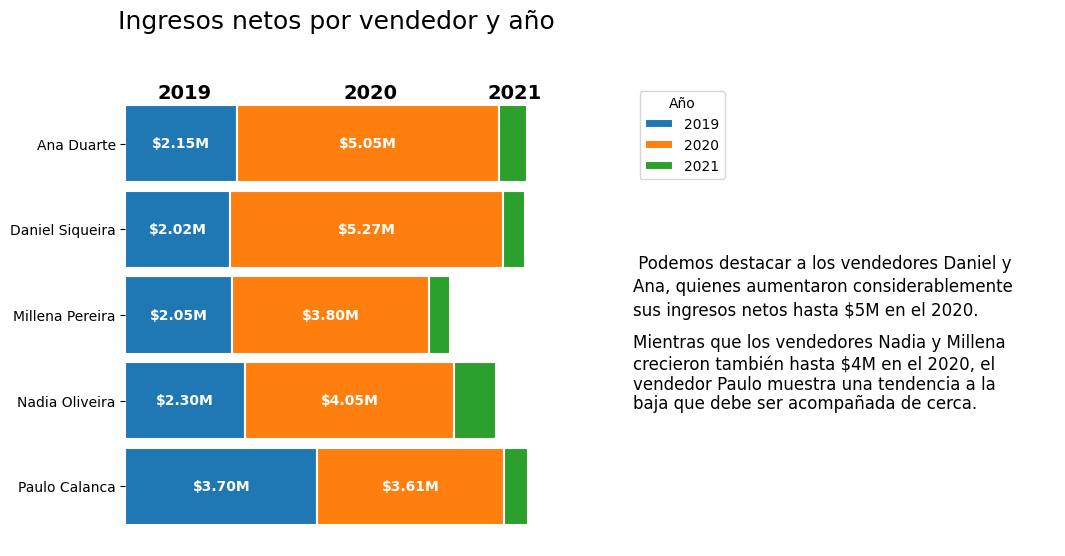

In [177]:
def crear_grafico_vendedores(data, años):
    labels = data.index
    data = data.values

    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(12, 6))
    ax1.invert_yaxis()
    ax1.xaxis.set_visible(False)

    # Eliminamos el cuadro delimitador alrededor del gráfico
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)

    ax1.set_title('')
    ax1.set_xlabel('')
    ax1.set_xticks([])

    ax1.set_title('Ingresos netos por vendedor y año', fontsize=18, pad=40)
    ax1.set_xlabel('Total ventas')
    ax1.set_ylabel('')
    ax1.legend('Año')
    ax1.get_legend().remove()


    for i, colname in enumerate(años):
        widths = data[:, i]
        starts = np.cumsum(data[:, :i], axis=1)[:, -1] if i > 0 else 0
        bars = ax1.barh(labels, widths, left=starts, height=0.9, edgecolor='white', linewidth=1.5,
                 label=colname)


        for bar, c in zip(bars, data[:, i]):
          # Omitimos el texto de ingresos netos por vendedor del 2021
            if colname != "2021":
                ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                         f'${c / 1000000:.2f}M', ha='center', va='center', color='white', fontweight='bold')

    ax1.legend(ncol=len(años), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    # Agregamos las ideas resaltantes del grafico
    ax2.text(0, 0.6, ' Podemos destacar a los vendedores Daniel y ', fontsize=12, ha='left')
    ax2.text(0, 0.55, 'Ana, quienes aumentaron considerablemente', fontsize=12, ha='left')
    ax2.text(0, 0.5,  'sus ingresos netos hasta $5M en el 2020.', fontsize=12, ha='left')
    ax2.text(0, 0.43, 'Mientras que los vendedores Nadia y Millena', fontsize=12, ha='left')
    ax2.text(0, 0.38, 'crecieron también hasta $4M en el 2020, el', fontsize=12, ha='left')
    ax2.text(0, 0.338, 'vendedor Paulo muestra una tendencia a la', fontsize=12, ha='left')
    ax2.text(0, 0.297, 'baja que debe ser acompañada de cerca.', fontsize=12, ha='left')
    ax2.axis('off')

    handles, labels = ax1.get_legend_handles_labels()
    ax2.legend(handles, labels, loc='upper left', title='Año')
    ax1.get_legend().remove()

    # Agregamos texto de los años "2019", "2020" y "2021" en negrita
    ax1.text(0.14, 0.98, '2019', ha='center', va='center', fontsize=14, fontweight='bold', transform=ax1.transAxes)
    ax1.text(0.58, 0.98, '2020', ha='center', va='center', fontsize=14, fontweight='bold', transform=ax1.transAxes)
    ax1.text(0.92, 0.98, '2021', ha='center', va='center', fontsize=14, fontweight='bold', transform=ax1.transAxes)


    return fig, (ax1, ax2)

crear_grafico_vendedores(df, ["2019", "2020", "2021"])
plt.show()

##**Pregunta 4: ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?**

In [178]:
query = 'SELECT cantidad, valor_unitario, valor_total, ciudad, costo_envio, valor_total - costo_envio as TOTAL_NETO FROM items_pedidos LIMIT 5;'
pd.read_sql(sql=text(query), con = database.connect())

,cantidad,valor_unitario,valor_total,ciudad,costo_envio,TOTAL_NETO
0,5,6175.0,30875.0,BR-RJ,6175.0,24700.0
1,3,200.0,600.0,BR-PB,120.0,480.0
2,6,139.0,834.0,BR-DF,166.8,667.2
3,3,525.0,1575.0,BR-BA,315.0,1260.0
4,3,179.0,537.0,BR-MG,107.4,429.6


In [179]:
query = 'SELECT COUNT(DISTINCT ciudad) AS Cantidad_ciudades FROM items_pedidos;'
pd.read_sql(sql=text(query), con = database.connect())

,Cantidad_ciudades
0,27


In [180]:
query = '''
SELECT ciudad, SUBSTR(ciudad, 4) as code, SUM(valor_total - costo_envio) as total_neto
FROM items_pedidos
GROUP BY ciudad
ORDER BY total_neto DESC
'''
cities = pd.read_sql(sql=text(query), con = database.connect())
cities

,ciudad,code,total_neto
0,BR-AL,AL,1522016.0
1,BR-PE,PE,1509197.6
2,BR-SC,SC,1476962.4
3,BR-AP,AP,1475737.6
4,BR-CE,CE,1468080.8
5,BR-MA,MA,1453059.2
6,BR-PB,PB,1423834.4
7,BR-GO,GO,1418205.6
8,BR-SP,SP,1404412.0
9,BR-MT,MT,1363611.2


Obteniendo coordenadas y convirtiendo DataFrame a GeoDataFrame

In [181]:
codes = [code for code in cities['code'].values]
geometries = []
for code in codes:
  for index, value in geobr.read_state(code)['geometry'].items():
    geometries.append(value)
cities['geometry'] = geometries
cities.set_geometry(col='geometry')
gpd_cities = geopandas.GeoDataFrame(cities)

In [182]:
gpd_cities.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ciudad      27 non-null     object  
 1   code        27 non-null     object  
 2   total_neto  27 non-null     float64 
 3   geometry    27 non-null     geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 992.0+ bytes


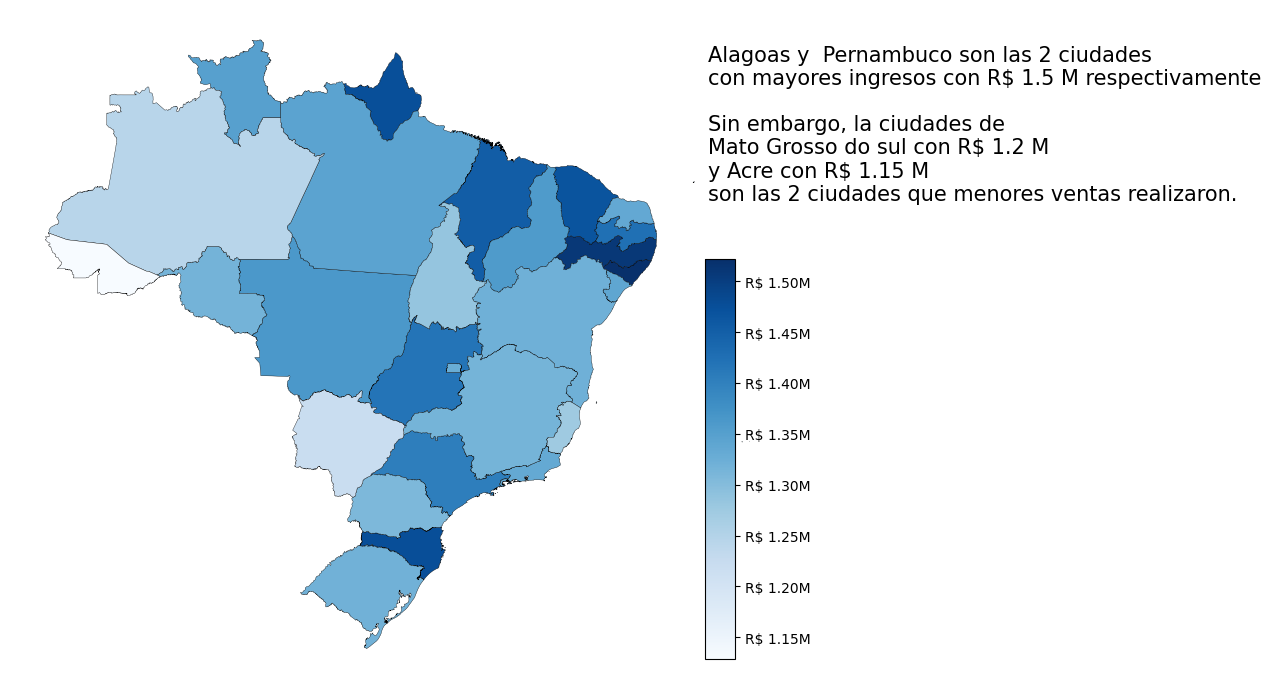

In [183]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
gpd_cities.plot(
  ax=ax,
  column='total_neto',
  cmap='Blues',
  edgecolor='black',
  linewidth=0.25
)

cax = fig.add_axes([0.82, 0.18, 0.03, 0.4])
sm = plt.cm.ScalarMappable(
  cmap='Blues',
  norm=plt.Normalize(
    vmin=gpd_cities['total_neto'].min(),
    vmax=gpd_cities['total_neto'].max()
  )
)

fig.colorbar(
  sm,
  cax=cax,
  format=ticker.FuncFormatter(lambda x, pos: f"R${x/1000000: .2f}M")
)

# plt.text(-10, 1500000, '-10, 1.5m')

ax.text(
  -31.5, -5,
  'Alagoas y  Pernambuco son las 2 ciudades \n'
  'con mayores ingresos con R$ 1.5 M respectivamente \n'
  '\n'
  'Sin embargo, la ciudades de \n'
  'Mato Grosso do sul con R$ 1.2 M \n'
  'y Acre con R$ 1.15 M \n'
  'son las 2 ciudades que menores ventas realizaron.',
  fontsize=15)

ax.set_axis_off();